# Importing Dataset

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! echo '{"username":"nandininarvekar","key":"29478554dcf0ed31807531970f436542"}' > /root/.kaggle/kaggle.json

In [ ]:
# ! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d paultimothymooney/kermany2018

100% 10.8G/10.8G [01:09<00:00, 179MB/s]
100% 10.8G/10.8G [01:09<00:00, 168MB/s]


In [ ]:
! unzip kermany2018

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [ ]:
import os
import numpy as np
import cv2
import time
from tqdm import tqdm
from google.colab.patches import cv2_imshow
import random


from PIL import Image
from matplotlib import pyplot as plt
from keras.utils import normalize
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam

import pickle
from glob import glob
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, concatenate, Input, Dropout, UpSampling2D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
import shutil
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
os.remove("kermany2018.zip")

In [ ]:
import os
os.rename("/content/OCT2017 /","/content/OCT2017/")

# Seeding

In [ ]:
os.environ['PYTHONHASHSEED'] = str(42)
np.random.seed(42)
tf.random.set_seed(42)

# Make directory structure

In [ ]:
os.mkdir("/content/masks/")
os.mkdir("/content/masks/test/")
os.mkdir("/content/masks/test/CNV/")
os.mkdir("/content/masks/test/DME/")
os.mkdir("/content/masks/test/DRUSEN/")
os.mkdir("/content/masks/test/NORMAL/")
os.mkdir("/content/masks/train/")
os.mkdir("/content/masks/train/CNV/")
os.mkdir("/content/masks/train/DME/")
os.mkdir("/content/masks/train/DRUSEN/")
os.mkdir("/content/masks/train/NORMAL/")
os.mkdir("/content/masks/val/")
os.mkdir("/content/masks/val/CNV/")
os.mkdir("/content/masks/val/DME/")
os.mkdir("/content/masks/val/DRUSEN/")
os.mkdir("/content/masks/val/NORMAL/")

In [ ]:
test_cnv = glob("/content/OCT2017/test/CNV/*.jpeg")
test_dme = glob("/content/OCT2017/test/DME/*.jpeg")
test_drusen = glob("/content/OCT2017/test/DRUSEN/*.jpeg")
test_normal = glob("/content/OCT2017/test/NORMAL/*.jpeg")

train_cnv = glob("/content/OCT2017/train/CNV/*.jpeg")
train_dme = glob("/content/OCT2017/train/DME/*.jpeg")
train_drusen = glob("/content/OCT2017/train/DRUSEN/*.jpeg")
train_normal = glob("/content/OCT2017/train/NORMAL/*.jpeg")

val_cnv = glob("/content/OCT2017/val/CNV/*.jpeg")
val_dme = glob("/content/OCT2017/val/DME/*.jpeg")
val_drusen = glob("/content/OCT2017/val/DRUSEN/*.jpeg")
val_normal = glob("/content/OCT2017/val/NORMAL/*.jpeg")

In [ ]:
masks_test_cnv = glob("/content/masks/test/CNV/")
masks_test_dme = glob("/content/masks/test/DME/")
masks_test_drusen = glob("/content/masks/test/DRUSEN/")
masks_test_normal = glob("/content/masks/test/NORMAL/")

masks_train_cnv = glob("/content/masks/train/CNV/")
masks_train_dme = glob("/content/masks/train/DME/")
masks_train_drusen = glob("/content/masks/train/DRUSEN/")
masks_train_normal = glob("/content/masks/train/NORMAL/")

masks_val_cnv = glob("/content/masks/val/CNV/")
masks_val_dme = glob("/content/masks/val/DME/")
masks_val_drusen = glob("/content/masks/val/DRUSEN/")
masks_val_normal = glob("/content/masks/val/NORMAL/")

In [ ]:
print(len(train_normal))

26315


# Creating Masks

In [ ]:
all_raw = ["/content/OCT2017/test/CNV/", "/content/OCT2017/test/DME/", "/content/OCT2017/test/DRUSEN/", "/content/OCT2017/test/NORMAL/",
           "/content/OCT2017/train/CNV/", "/content/OCT2017/train/DME/", "/content/OCT2017/train/DRUSEN/", "/content/OCT2017/train/NORMAL/",
           "/content/OCT2017/val/CNV/", "/content/OCT2017/val/DME/", "/content/OCT2017/val/DRUSEN/", "/content/OCT2017/val/NORMAL/"]

all_masks = ["/content/masks/test/CNV/", "/content/masks/test/DME/", "/content/masks/test/DRUSEN/", "/content/masks/test/NORMAL/",
           "/content/masks/train/CNV/", "/content/masks/train/DME/", "/content/masks/train/DRUSEN/", "/content/masks/train/NORMAL/",
           "/content/masks/val/CNV/", "/content/masks/val/DME/", "/content/masks/val/DRUSEN/", "/content/masks/val/NORMAL/"]


In [ ]:
all_raw_var = [test_cnv, test_dme, test_drusen, test_normal,train_cnv, train_dme, train_drusen, train_normal, val_cnv, val_dme, val_drusen, val_normal]

all_masks_var = [masks_test_cnv, masks_test_dme, masks_test_drusen, masks_test_normal, masks_train_cnv, masks_train_dme, masks_train_drusen, masks_train_normal, masks_val_cnv, masks_val_dme, masks_val_drusen, masks_val_normal]

In [ ]:
# for dir in all_raw_var:
#     for path in tqdm(dir, total = len(dir)):
#         name = path.split("/")[-1].split(".")[0]

## Test Folder

In [ ]:
# CNV

# --------
source_folder = test_cnv
dest_folder = masks_test_cnv
color_lower_limit = 90
color_upper_limit = 255
# --------

for path in tqdm(source_folder, total = len(source_folder)):
    name = path.split("/")[-1].split(".")[0]

    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(gray, color_lower_limit, color_upper_limit, cv2.THRESH_BINARY)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    binary_mask = cv2.erode(binary_mask, kernel, iterations=1)
    binary_mask = cv2.dilate(binary_mask, kernel, iterations=1)

    cv2.imwrite("{}{}.jpeg".format(dest_folder[0],name), binary_mask)

100%|██████████| 242/242 [00:01<00:00, 168.29it/s]


In [ ]:
# DME

# --------
source_folder = test_dme
dest_folder = masks_test_dme
color_lower_limit = 40
color_upper_limit = 255
# --------

for path in tqdm(source_folder, total = len(source_folder)):
    name = path.split("/")[-1].split(".")[0]

    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(gray, color_lower_limit, color_upper_limit, cv2.THRESH_BINARY)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    binary_mask = cv2.erode(binary_mask, kernel, iterations=1)
    binary_mask = cv2.dilate(binary_mask, kernel, iterations=1)

    cv2.imwrite("{}{}.jpeg".format(dest_folder[0],name), binary_mask)

100%|██████████| 242/242 [00:01<00:00, 168.99it/s]


In [ ]:
# DRUSEN

# --------
source_folder = test_drusen
dest_folder = masks_test_drusen
color_lower_limit = 40
color_upper_limit = 255
# --------

for path in tqdm(source_folder, total = len(source_folder)):
    name = path.split("/")[-1].split(".")[0]

    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(gray, color_lower_limit, color_upper_limit, cv2.THRESH_BINARY)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    binary_mask = cv2.erode(binary_mask, kernel, iterations=1)
    binary_mask = cv2.dilate(binary_mask, kernel, iterations=1)

    cv2.imwrite("{}{}.jpeg".format(dest_folder[0],name), binary_mask)

100%|██████████| 242/242 [00:01<00:00, 186.84it/s]


In [ ]:
# NORMAL

# --------
source_folder = test_normal
dest_folder = masks_test_normal
color_lower_limit = 100
color_upper_limit = 255
# --------

for path in tqdm(source_folder, total = len(source_folder)):
    name = path.split("/")[-1].split(".")[0]

    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(gray, color_lower_limit, color_upper_limit, cv2.THRESH_BINARY)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    binary_mask = cv2.erode(binary_mask, kernel, iterations=1)
    binary_mask = cv2.dilate(binary_mask, kernel, iterations=1)

    cv2.imwrite("{}{}.jpeg".format(dest_folder[0],name), binary_mask)

100%|██████████| 242/242 [00:01<00:00, 198.59it/s]


## Train Folder

In [ ]:
# CNV

# --------
source_folder = train_cnv
dest_folder = masks_train_cnv
color_lower_limit = 90
color_upper_limit = 255
# --------

for path in tqdm(source_folder, total = len(source_folder)):
    name = path.split("/")[-1].split(".")[0]

    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(gray, color_lower_limit, color_upper_limit, cv2.THRESH_BINARY)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    binary_mask = cv2.erode(binary_mask, kernel, iterations=1)
    binary_mask = cv2.dilate(binary_mask, kernel, iterations=1)

    cv2.imwrite("{}{}.jpeg".format(dest_folder[0],name), binary_mask)

100%|██████████| 37205/37205 [05:01<00:00, 123.45it/s]


In [ ]:
# DME

# --------
source_folder = train_dme
dest_folder = masks_train_dme
color_lower_limit = 40
color_upper_limit = 255
# --------

for path in tqdm(source_folder, total = len(source_folder)):
    name = path.split("/")[-1].split(".")[0]

    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(gray, color_lower_limit, color_upper_limit, cv2.THRESH_BINARY)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    binary_mask = cv2.erode(binary_mask, kernel, iterations=1)
    binary_mask = cv2.dilate(binary_mask, kernel, iterations=1)

    cv2.imwrite("{}{}.jpeg".format(dest_folder[0],name), binary_mask)

100%|██████████| 11348/11348 [01:19<00:00, 142.24it/s]


In [ ]:
# DRUSEN

# --------
source_folder = train_drusen
dest_folder = masks_train_drusen
color_lower_limit = 40
color_upper_limit = 255
# --------

for path in tqdm(source_folder, total = len(source_folder)):
    name = path.split("/")[-1].split(".")[0]

    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(gray, color_lower_limit, color_upper_limit, cv2.THRESH_BINARY)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    binary_mask = cv2.erode(binary_mask, kernel, iterations=1)
    binary_mask = cv2.dilate(binary_mask, kernel, iterations=1)

    cv2.imwrite("{}{}.jpeg".format(dest_folder[0],name), binary_mask)

100%|██████████| 8616/8616 [01:04<00:00, 133.11it/s]


In [ ]:
# NORMAL

# --------
source_folder = train_normal
dest_folder = masks_train_normal
color_lower_limit = 100
color_upper_limit = 255
# --------

for path in tqdm(source_folder, total = len(source_folder)):
    name = path.split("/")[-1].split(".")[0]

    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(gray, color_lower_limit, color_upper_limit, cv2.THRESH_BINARY)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    binary_mask = cv2.erode(binary_mask, kernel, iterations=1)
    binary_mask = cv2.dilate(binary_mask, kernel, iterations=1)

    cv2.imwrite("{}{}.jpeg".format(dest_folder[0],name), binary_mask)

100%|██████████| 26315/26315 [03:10<00:00, 137.80it/s]


## Validation Folder

In [ ]:
# CNV

# --------
source_folder = val_cnv
dest_folder = masks_val_cnv
color_lower_limit = 90
color_upper_limit = 255
# --------

for path in tqdm(source_folder, total = len(source_folder)):
    name = path.split("/")[-1].split(".")[0]

    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(gray, color_lower_limit, color_upper_limit, cv2.THRESH_BINARY)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    binary_mask = cv2.erode(binary_mask, kernel, iterations=1)
    binary_mask = cv2.dilate(binary_mask, kernel, iterations=1)

    cv2.imwrite("{}{}.jpeg".format(dest_folder[0],name), binary_mask)

100%|██████████| 8/8 [00:00<00:00, 178.07it/s]


In [ ]:
# DME

# --------
source_folder = val_dme
dest_folder = masks_val_dme
color_lower_limit = 40
color_upper_limit = 255
# --------

for path in tqdm(source_folder, total = len(source_folder)):
    name = path.split("/")[-1].split(".")[0]

    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(gray, color_lower_limit, color_upper_limit, cv2.THRESH_BINARY)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    binary_mask = cv2.erode(binary_mask, kernel, iterations=1)
    binary_mask = cv2.dilate(binary_mask, kernel, iterations=1)

    cv2.imwrite("{}{}.jpeg".format(dest_folder[0],name), binary_mask)

100%|██████████| 8/8 [00:00<00:00, 178.26it/s]


In [ ]:
# DRUSEN

# --------
source_folder = val_drusen
dest_folder = masks_val_drusen
color_lower_limit = 40
color_upper_limit = 255
# --------

for path in tqdm(source_folder, total = len(source_folder)):
    name = path.split("/")[-1].split(".")[0]

    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(gray, color_lower_limit, color_upper_limit, cv2.THRESH_BINARY)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    binary_mask = cv2.erode(binary_mask, kernel, iterations=1)
    binary_mask = cv2.dilate(binary_mask, kernel, iterations=1)

    cv2.imwrite("{}{}.jpeg".format(dest_folder[0],name), binary_mask)

100%|██████████| 8/8 [00:00<00:00, 187.94it/s]


In [ ]:
# NORMAL

# --------
source_folder = val_normal
dest_folder = masks_val_normal
color_lower_limit = 100
color_upper_limit = 255
# --------

for path in tqdm(source_folder, total = len(source_folder)):
    name = path.split("/")[-1].split(".")[0]

    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(gray, color_lower_limit, color_upper_limit, cv2.THRESH_BINARY)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    binary_mask = cv2.erode(binary_mask, kernel, iterations=1)
    binary_mask = cv2.dilate(binary_mask, kernel, iterations=1)

    cv2.imwrite("{}{}.jpeg".format(dest_folder[0],name), binary_mask)

100%|██████████| 8/8 [00:00<00:00, 209.67it/s]


## Sample

In [ ]:
# img = cv2.imread('/content/OCT2017/val/DME/DME-9603124-1.jpeg')
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# _, binary_mask = cv2.threshold(gray, 40, 150, cv2.THRESH_BINARY)

# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
# binary_mask = cv2.erode(binary_mask, kernel, iterations=1)
# binary_mask = cv2.dilate(binary_mask, kernel, iterations=1)

# cv2.imwrite('binary_mask.jpg', binary_mask)

In [ ]:
# "{}{}.jpeg".format(masks_val_cnv[0],name)

---

---

# Move all images to one folder for unet training

In [ ]:
'''
def make_new_folder(folder_name, parent_folder):
    path = os.path.join(parent_folder, folder_name)
    try:
        os.mkdir(path)
    except OSError as error:
        print(error)



current_folder = os.getcwd()
# list_dir = ['/content/OCT2017/train/CNV', '/content/OCT2017/train/DME', '/content/OCT2017/train/DRUSEN', '/content/OCT2017/train/NORMAL']
list_dir = ['/content/OCT2017/test/CNV', '/content/OCT2017/test/DME', '/content/OCT2017/test/DRUSEN', '/content/OCT2017/test/NORMAL']
# list_dir = ['/content/OCT2017/val/CNV', '/content/OCT2017/val/DME', '/content/OCT2017/val/DRUSEN', '/content/OCT2017/val/NORMAL']

content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

merge_folder = "unet_training_images"
merge_folder_path = os.path.join(current_folder, merge_folder)
make_new_folder(merge_folder, current_folder)

for sub_dir in content_list:
    for contents in content_list[sub_dir]:
        path_to_content = sub_dir + "/" + contents
        dir_to_move = os.path.join(current_folder, path_to_content )
        shutil.copy(dir_to_move, merge_folder_path)

'''

'\ndef make_new_folder(folder_name, parent_folder):\n    path = os.path.join(parent_folder, folder_name)\n    try: \n        os.mkdir(path) \n    except OSError as error: \n        print(error)\n\n\n\ncurrent_folder = os.getcwd() \n# list_dir = [\'/content/OCT2017/train/CNV\', \'/content/OCT2017/train/DME\', \'/content/OCT2017/train/DRUSEN\', \'/content/OCT2017/train/NORMAL\']\nlist_dir = [\'/content/OCT2017/test/CNV\', \'/content/OCT2017/test/DME\', \'/content/OCT2017/test/DRUSEN\', \'/content/OCT2017/test/NORMAL\']\n# list_dir = [\'/content/OCT2017/val/CNV\', \'/content/OCT2017/val/DME\', \'/content/OCT2017/val/DRUSEN\', \'/content/OCT2017/val/NORMAL\']\n  \ncontent_list = {}\nfor index, val in enumerate(list_dir):\n    path = os.path.join(current_folder, val)\n    content_list[ list_dir[index] ] = os.listdir(path)\n\nmerge_folder = "unet_training_images"\nmerge_folder_path = os.path.join(current_folder, merge_folder) \nmake_new_folder(merge_folder, current_folder)\n\nfor sub_dir in 

In [ ]:
'''
import os
APP_FOLDER = '/content/unet_training_images'
totalFiles = 0
totalDir = 0
for base, dirs, files in os.walk(APP_FOLDER):
    print('Searching in : ',base)
    for directories in dirs:
        totalDir += 1
    for Files in files:
        totalFiles += 1

print('Total number of files',totalFiles)
print('Total Number of directories',totalDir)
print('Total:',(totalDir + totalFiles))
'''

"\nimport os\nAPP_FOLDER = '/content/unet_training_images'\ntotalFiles = 0\ntotalDir = 0\nfor base, dirs, files in os.walk(APP_FOLDER):\n    print('Searching in : ',base)\n    for directories in dirs:\n        totalDir += 1\n    for Files in files:\n        totalFiles += 1\n\nprint('Total number of files',totalFiles)\nprint('Total Number of directories',totalDir)\nprint('Total:',(totalDir + totalFiles))\n"

# Move all masks to one folder for unet training

In [ ]:
# the images taken here will be from the test folder
'''

def make_new_folder(folder_name, parent_folder):
    path = os.path.join(parent_folder, folder_name)
    try:
        os.mkdir(path)
    except OSError as error:
        print(error)



current_folder = os.getcwd()
# list_dir = ['/content/masks/train/CNV', '/content/masks/train/DME', '/content/masks/train/DRUSEN', '/content/masks/train/NORMAL']
list_dir = ['/content/masks/test/CNV', '/content/masks/test/DME', '/content/masks/test/DRUSEN', '/content/masks/test/NORMAL']
# list_dir = ['/content/masks/val/CNV', '/content/masks/val/DME', '/content/masks/val/DRUSEN', '/content/masks/val/NORMAL']

content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

merge_folder = "unet_training_masks"
merge_folder_path = os.path.join(current_folder, merge_folder)
make_new_folder(merge_folder, current_folder)

for sub_dir in content_list:
    for contents in content_list[sub_dir]:
        path_to_content = sub_dir + "/" + contents
        dir_to_move = os.path.join(current_folder, path_to_content )
        shutil.copy(dir_to_move, merge_folder_path)

'''

'\n\ndef make_new_folder(folder_name, parent_folder):\n    path = os.path.join(parent_folder, folder_name)\n    try: \n        os.mkdir(path) \n    except OSError as error: \n        print(error)\n\n\n\ncurrent_folder = os.getcwd() \n# list_dir = [\'/content/masks/train/CNV\', \'/content/masks/train/DME\', \'/content/masks/train/DRUSEN\', \'/content/masks/train/NORMAL\']\nlist_dir = [\'/content/masks/test/CNV\', \'/content/masks/test/DME\', \'/content/masks/test/DRUSEN\', \'/content/masks/test/NORMAL\']\n# list_dir = [\'/content/masks/val/CNV\', \'/content/masks/val/DME\', \'/content/masks/val/DRUSEN\', \'/content/masks/val/NORMAL\']\n  \ncontent_list = {}\nfor index, val in enumerate(list_dir):\n    path = os.path.join(current_folder, val)\n    content_list[ list_dir[index] ] = os.listdir(path)\n\nmerge_folder = "unet_training_masks"\nmerge_folder_path = os.path.join(current_folder, merge_folder) \nmake_new_folder(merge_folder, current_folder)\n\nfor sub_dir in content_list:\n    for 

In [ ]:

'''
import os
APP_FOLDER = '/content/unet_training_masks'
totalFiles = 0
totalDir = 0
for base, dirs, files in os.walk(APP_FOLDER):
    print('Searching in : ',base)
    for directories in dirs:
        totalDir += 1
    for Files in files:
        totalFiles += 1

print('Total number of files',totalFiles)
print('Total Number of directories',totalDir)
print('Total:',(totalDir + totalFiles))
'''

"\nimport os\nAPP_FOLDER = '/content/unet_training_masks'\ntotalFiles = 0\ntotalDir = 0\nfor base, dirs, files in os.walk(APP_FOLDER):\n    print('Searching in : ',base)\n    for directories in dirs:\n        totalDir += 1\n    for Files in files:\n        totalFiles += 1\n\nprint('Total number of files',totalFiles)\nprint('Total Number of directories',totalDir)\nprint('Total:',(totalDir + totalFiles))\n"





---


# OR


---







# Move 25 random images from each set and corresponding masks to training set

In [ ]:
# import os
# import glob

# files = glob.glob('/content/unet_training_images/*.jpeg')
# for f in files:
#     os.remove(f)

## Train CNV

In [ ]:
os.mkdir("/content/unet_training_images/")
os.mkdir("/content/unet_training_masks/")

In [ ]:
image_files_list = []
mask_files_list = []


sourceImgPath = "/content/OCT2017/train/CNV/"
sourceMaskPath = "/content/masks/train/CNV/"
destImgPath = "/content/unet_training_images/"
destMaskPath = "/content/unet_training_masks/"

for root, dirs, files in os.walk(sourceImgPath):
    for file in files:
        if file.endswith(".jpeg"):
            image_files_list.append(os.path.join(root, file))


file_count = len(image_files_list)
print (file_count)

# print image_files_list
filesToCopy = random.sample(image_files_list, 25)

masksToCopy = [sub.replace("/content/OCT2017/train/CNV/", "/content/masks/train/CNV/") for sub in filesToCopy]

print(len(filesToCopy))
print(len(masksToCopy))


# iterate over all random files and move them
for file in filesToCopy:
    shutil.copy(file, destImgPath)

for file in masksToCopy:
    shutil.copy(file, destMaskPath)

37205
25
25


## Train DME

In [ ]:
image_files_list = []
mask_files_list = []


sourceImgPath = "/content/OCT2017/train/DME/"
sourceMaskPath = "/content/masks/train/DME/"
destImgPath = "/content/unet_training_images/"
destMaskPath = "/content/unet_training_masks/"

for root, dirs, files in os.walk(sourceImgPath):
    for file in files:
        if file.endswith(".jpeg"):
            image_files_list.append(os.path.join(root, file))




# print image_files_list
filesToCopy = random.sample(image_files_list, 25)

masksToCopy = [sub.replace("/content/OCT2017/train/DME/", "/content/masks/train/DME/") for sub in filesToCopy]


print (len(image_files_list))
print (len(filesToCopy))
print (len(masksToCopy))

# iterate over all random files and move them
for file in filesToCopy:
    shutil.copy(file, destImgPath)

for file in masksToCopy:
    shutil.copy(file, destMaskPath)




11348
25
25


## Train DRUSEN

In [ ]:
image_files_list = []
mask_files_list = []


sourceImgPath = "/content/OCT2017/train/DRUSEN/"
sourceMaskPath = "/content/masks/train/DRUSEN/"
destImgPath = "/content/unet_training_images/"
destMaskPath = "/content/unet_training_masks/"

for root, dirs, files in os.walk(sourceImgPath):
    for file in files:
        if file.endswith(".jpeg"):
            image_files_list.append(os.path.join(root, file))


# print image_files_list
filesToCopy = random.sample(image_files_list, 25)

masksToCopy = [sub.replace("/content/OCT2017/train/DRUSEN/", "/content/masks/train/DRUSEN/") for sub in filesToCopy]

print (len(image_files_list))
print (len(filesToCopy))
print (len(masksToCopy))

# iterate over all random files and move them
for file in filesToCopy:
    shutil.copy(file, destImgPath)

for file in masksToCopy:
    shutil.copy(file, destMaskPath)


8616
25
25


## Train NORMAL

In [ ]:
image_files_list = []
mask_files_list = []


sourceImgPath = "/content/OCT2017/train/NORMAL/"
sourceMaskPath = "/content/masks/train/NORMAL/"
destImgPath = "/content/unet_training_images/"
destMaskPath = "/content/unet_training_masks/"

for root, dirs, files in os.walk(sourceImgPath):
    for file in files:
        if file.endswith(".jpeg"):
            image_files_list.append(os.path.join(root, file))

print (len(image_files_list))
print (len(filesToCopy))
print (len(masksToCopy))

# print image_files_list
filesToCopy = random.sample(image_files_list, 25)

masksToCopy = [sub.replace("/content/OCT2017/train/NORMAL/", "/content/masks/train/NORMAL/") for sub in filesToCopy]


# iterate over all random files and move them
for file in filesToCopy:
    shutil.copy(file, destImgPath)

for file in masksToCopy:
    shutil.copy(file, destMaskPath)


26315
25
25


---
---

In [ ]:
len(glob('/content/unet_training_masks/*.jpeg'))

100

# Resize all images to 496 by 496

In [ ]:
os.rename("/content/unet_training_images","/content/raw_unet_training_images")

In [ ]:
os.rename("/content/unet_training_masks","/content/raw_unet_training_masks")

In [ ]:
os.mkdir("/content/unet_training_masks")
os.mkdir("/content/unet_training_images")

## Images

In [ ]:
from PIL import Image
import os

# Set the source and destination folders
src_folder = "/content/raw_unet_training_images"
dst_folder = "/content/unet_training_images"

# Set the target size
target_size = (496, 496)

# Iterate through all files in the source folder
for filename in os.listdir(src_folder):
    # Check if the file is an image file
    if filename.endswith(".jpeg"):
        # Load the image
        img = Image.open(os.path.join(src_folder, filename))

        # Resize the image to the target size
        resized_img = img.resize(target_size)

        # Save the resized image to the destination folder
        resized_img.save(os.path.join(dst_folder, filename))


## Masks

In [ ]:
from PIL import Image
import os

# Set the source and destination folders
src_folder = "/content/raw_unet_training_masks"
dst_folder = "/content/unet_training_masks"

# Set the target size
target_size = (496, 496)

# Iterate through all files in the source folder
for filename in os.listdir(src_folder):
    # Check if the file is an image file
    if filename.endswith(".jpeg"):
        # Load the image
        img = Image.open(os.path.join(src_folder, filename))

        # Resize the image to the target size
        resized_img = img.resize(target_size)

        # Save the resized image to the destination folder
        resized_img.save(os.path.join(dst_folder, filename))


# UNET Architecture


In [ ]:
image_directory = '/content/unet_training_images/'
mask_directory = '/content/unet_training_masks/'

In [ ]:
import os
import numpy as np
import cv2
import time
from tqdm import tqdm
from google.colab.patches import cv2_imshow
import random


from PIL import Image
from matplotlib import pyplot as plt
from keras.utils import normalize
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam

import pickle
from glob import glob
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, concatenate, Input, Dropout, UpSampling2D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
import shutil
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
image_names = glob('/content/unet_training_images/*.jpeg')
print(image_names)

['/content/unet_training_images/DRUSEN-5743416-17.jpeg', '/content/unet_training_images/CNV-1083927-211.jpeg', '/content/unet_training_images/DME-7918201-25.jpeg', '/content/unet_training_images/CNV-6695669-5.jpeg', '/content/unet_training_images/CNV-9297624-117.jpeg', '/content/unet_training_images/DRUSEN-3439251-25.jpeg', '/content/unet_training_images/DRUSEN-9894035-24.jpeg', '/content/unet_training_images/NORMAL-544711-6.jpeg', '/content/unet_training_images/CNV-1016042-6.jpeg', '/content/unet_training_images/DRUSEN-568518-4.jpeg', '/content/unet_training_images/DME-8218042-18.jpeg', '/content/unet_training_images/DRUSEN-1347813-2.jpeg', '/content/unet_training_images/DRUSEN-1193659-1.jpeg', '/content/unet_training_images/NORMAL-4921376-66.jpeg', '/content/unet_training_images/CNV-364469-102.jpeg', '/content/unet_training_images/DME-6737988-42.jpeg', '/content/unet_training_images/NORMAL-4928492-5.jpeg', '/content/unet_training_images/DRUSEN-6010249-13.jpeg', '/content/unet_trainin

In [ ]:
image_names.sort()

In [ ]:
print(image_names)

['/content/unet_training_images/CNV-1016042-6.jpeg', '/content/unet_training_images/CNV-1016042-67.jpeg', '/content/unet_training_images/CNV-1083927-211.jpeg', '/content/unet_training_images/CNV-172183-3.jpeg', '/content/unet_training_images/CNV-1982250-24.jpeg', '/content/unet_training_images/CNV-2116022-69.jpeg', '/content/unet_training_images/CNV-3080163-25.jpeg', '/content/unet_training_images/CNV-3574650-52.jpeg', '/content/unet_training_images/CNV-3616460-32.jpeg', '/content/unet_training_images/CNV-364469-102.jpeg', '/content/unet_training_images/CNV-4219137-119.jpeg', '/content/unet_training_images/CNV-4921376-127.jpeg', '/content/unet_training_images/CNV-53264-7.jpeg', '/content/unet_training_images/CNV-6566667-118.jpeg', '/content/unet_training_images/CNV-6566667-136.jpeg', '/content/unet_training_images/CNV-6569286-120.jpeg', '/content/unet_training_images/CNV-6581164-58.jpeg', '/content/unet_training_images/CNV-6652117-434.jpeg', '/content/unet_training_images/CNV-6695669-5

In [ ]:
images = [cv2.imread(img, 0) for img in image_names]

In [ ]:
image_dataset = np.array(images)

In [ ]:
image_dataset = np.expand_dims(image_dataset, axis = 3)

In [ ]:
mask_names = glob('/content/unet_training_masks/*.jpeg')
mask_names.sort()
masks = [cv2.imread(mask, 0) for mask in mask_names]
mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)

In [ ]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (100, 496, 496, 1)
Mask data shape is:  (100, 496, 496, 1)
Max pixel value in image is:  255
Labels in the mask are :  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211

In [ ]:
#Normalize images
image_dataset = image_dataset /255.  #Can also normalize or scale using MinMax scaler
#Do not normalize masks, just rescale to 0 to 1.
mask_dataset = mask_dataset /255.  #PIxel values will be 0 or 1

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)

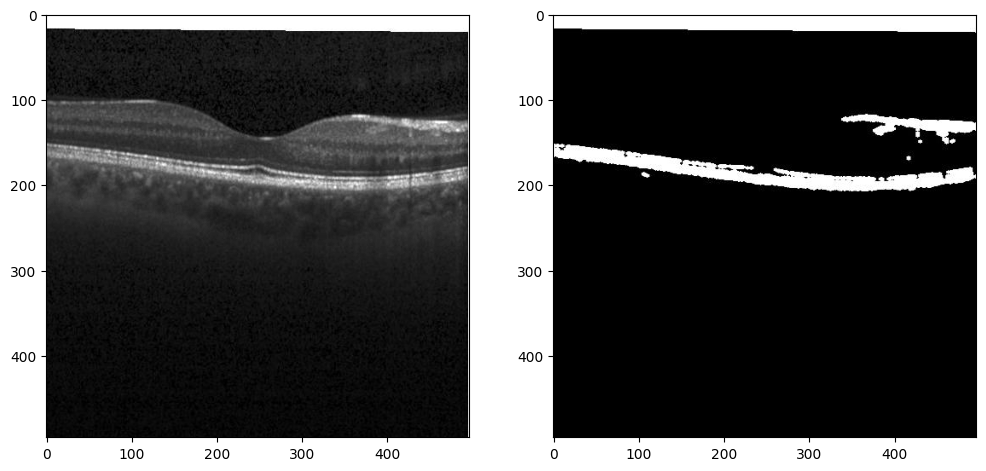

In [ ]:
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')
plt.show()

In [ ]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [ ]:
# batch_size = 16
# epochs = 100
# IMG_HEIGHT = 496
# IMG_WIDTH = 512
# IMG_CHANNELS = 3

In [ ]:
# Define input shape
input_shape = (496, 496, 1)

# Define the number of filters
num_filters = 64

# Define the number of classes
num_classes = 1

# Define the input layer
inputs = Input(input_shape)

# Define the contracting (downsampling) path
conv1 = Conv2D(num_filters, 3, activation="relu", padding="same")(inputs)
conv1 = Conv2D(num_filters, 3, activation="relu", padding="same")(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(num_filters * 2, 3, activation="relu", padding="same")(pool1)
conv2 = Conv2D(num_filters * 2, 3, activation="relu", padding="same")(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(num_filters * 4, 3, activation="relu", padding="same")(pool2)
conv3 = Conv2D(num_filters * 4, 3, activation="relu", padding="same")(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(num_filters * 8, 3, activation="relu", padding="same")(pool3)
conv4 = Conv2D(num_filters * 8, 3, activation="relu", padding="same")(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(num_filters * 16, 3, activation="relu", padding="same")(pool4)
conv5 = Conv2D(num_filters * 16, 3, activation="relu", padding="same")(conv5)
drop5 = Dropout(0.5)(conv5)

# Define the expanding (upsampling) path
up6 = Conv2D(num_filters * 8, 2, activation="relu", padding="same")(UpSampling2D(size=(2, 2))(drop5))
merge6 = concatenate([drop4, up6], axis=3)
conv6 = Conv2D(num_filters * 8, 3, activation="relu", padding="same")(merge6)
conv6 = Conv2D(num_filters * 8, 3, activation="relu", padding="same")(conv6)

up7 = Conv2D(num_filters * 4, 2, activation="relu", padding="same")(UpSampling2D(size=(2, 2))(conv6))
merge7 = concatenate([conv3, up7], axis=3)
conv7 = Conv2D(num_filters * 4, 3, activation="relu", padding="same")(merge7)
conv7 = Conv2D(num_filters * 4, 3, activation="relu", padding="same")(conv7)

up8 = Conv2D(num_filters * 2, 2, activation="relu", padding="same")(UpSampling2D(size=(2, 2))(conv7))
merge8 = concatenate([conv2, up8], axis=3)
conv8 = Conv2D(num_filters * 2, 3, activation="relu", padding="same")(merge8)
conv8 = Conv2D(num_filters * 2, 3, activation="relu", padding="same")(conv8)

up9 = Conv2D(num_filters, 2, activation="relu", padding="same")(UpSampling2D(size=(2, 2))(conv8))
merge9 = concatenate([conv1, up9], axis=3)
conv9 = Conv2D(num_filters, 3, activation="relu", padding="same")(merge9)
conv9 = Conv2D(num_filters, 3, activation="relu", padding="same")(conv9)

# Define the output layer with softmax activation function
outputs = Conv2D(num_classes, 1, activation="sigmoid")(conv9)

# Create the U-Net model
model = Model(inputs=inputs, outputs=outputs)



In [ ]:
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 496, 496, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 496, 496, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 496, 496, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size = 4,
                    verbose=1,
                    epochs=25,
                    validation_data=(X_test, y_test),
                    shuffle=False)

Epoch 1/25
20/20 [==============================] - 58s 1s/step - loss: 0.7570 - accuracy: 0.7781 - val_loss: 0.2214 - val_accuracy: 0.8484
Epoch 2/25
20/20 [==============================] - 25s 1s/step - loss: 0.2511 - accuracy: 0.8593 - val_loss: 0.1958 - val_accuracy: 0.8536
Epoch 3/25
20/20 [==============================] - 26s 1s/step - loss: 0.2031 - accuracy: 0.8535 - val_loss: 0.1907 - val_accuracy: 0.8447
Epoch 4/25
20/20 [==============================] - 26s 1s/step - loss: 0.1773 - accuracy: 0.8644 - val_loss: 0.1865 - val_accuracy: 0.8498
Epoch 5/25
20/20 [==============================] - 26s 1s/step - loss: 0.1703 - accuracy: 0.8647 - val_loss: 0.1843 - val_accuracy: 0.8504
Epoch 6/25
20/20 [==============================] - 26s 1s/step - loss: 0.1655 - accuracy: 0.8655 - val_loss: 0.1893 - val_accuracy: 0.8523
Epoch 7/25
20/20 [==============================] - 26s 1s/step - loss: 0.1650 - accuracy: 0.8662 - val_loss: 0.2005 - val_accuracy: 0.8529
Epoch 8/25
20/20 [==

In [ ]:
#Save the model for future use
model.save('/content/unet_model_25epochs_100i_2.h5')

In [ ]:
with open('unet_model_25epochs_100i_2.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
!cp "/content/unet_model_25epochs_100i_2.pkl" "/content/drive/My Drive/Models"

In [ ]:
!cp "/content/unet_model_25epochs_100i_2.h5" "/content/drive/My Drive/Models"

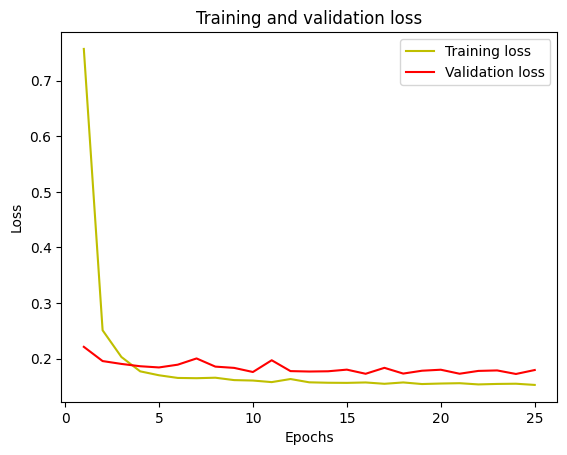

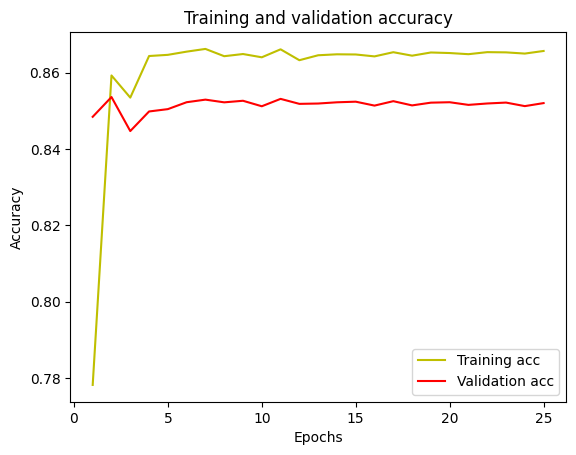

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from tensorflow import keras
model = keras.models.load_model('unet_model_25epochs_100i_2.h5')

In [ ]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

1/1 [==============================] - 34s 34s/step


In [ ]:
from keras.metrics import MeanIoU

In [ ]:

n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.7187375


(1, 496, 496, 1)
1/1 [==============================] - 3s 3s/step
(496, 496)


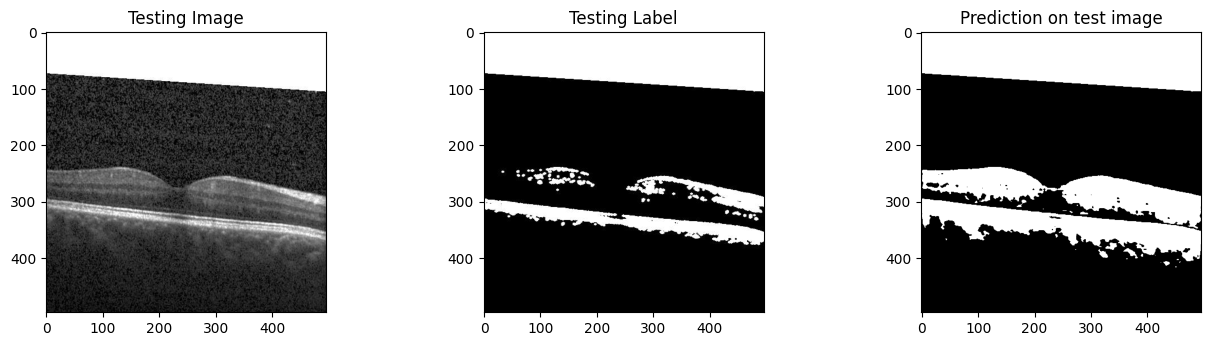

In [ ]:

threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

# Create Resized Dataset

In [ ]:
os.mkdir('/content/resized/')
os.mkdir('/content/resized/CNV/')
os.mkdir('/content/resized/DME/')
os.mkdir('/content/resized/DRUSEN/')
os.mkdir('/content/resized/NORMAL/')

In [ ]:
import os
import random
import cv2

# Set source and destination directories
src_dir = '/content/OCT2017/train/CNV/'
dst_dir = '/content/resized/CNV/'

# Set desired size
size = (496, 496)

# Collect list of all image files in source directory and its subdirectories
image_list = []
for root, dirs, files in os.walk(src_dir):
    for file in files:
        if file.endswith(('jpeg')):
            image_list.append(os.path.join(root, file))

# Select 2000 random images from the list
random_images = random.sample(image_list, 2000)

# Loop through random images, resize them, and save to destination directory
for img_path in random_images:
    # Load image
    img = cv2.imread(img_path)

    # Resize image
    img_resized = cv2.resize(img, size)

    # Get destination file path
    dst_path = os.path.join(dst_dir, os.path.basename(img_path))

    # Save resized image to destination directory
    cv2.imwrite(dst_path, img_resized)


In [ ]:
import os
import random
import cv2

# Set source and destination directories
src_dir = '/content/OCT2017/train/DME/'
dst_dir = '/content/resized/DME/'

# Set desired size
size = (496, 496)

# Collect list of all image files in source directory and its subdirectories
image_list = []
for root, dirs, files in os.walk(src_dir):
    for file in files:
        if file.endswith(('jpeg')):
            image_list.append(os.path.join(root, file))

# Select 2000 random images from the list
random_images = random.sample(image_list, 2000)

# Loop through random images, resize them, and save to destination directory
for img_path in random_images:
    # Load image
    img = cv2.imread(img_path)

    # Resize image
    img_resized = cv2.resize(img, size)

    # Get destination file path
    dst_path = os.path.join(dst_dir, os.path.basename(img_path))

    # Save resized image to destination directory
    cv2.imwrite(dst_path, img_resized)


In [ ]:
import os
import random
import cv2

# Set source and destination directories
src_dir = '/content/OCT2017/train/DRUSEN/'
dst_dir = '/content/resized/DRUSEN/'

# Set desired size
size = (496, 496)

# Collect list of all image files in source directory and its subdirectories
image_list = []
for root, dirs, files in os.walk(src_dir):
    for file in files:
        if file.endswith(('jpeg')):
            image_list.append(os.path.join(root, file))

# Select 2000 random images from the list
random_images = random.sample(image_list, 2000)

# Loop through random images, resize them, and save to destination directory
for img_path in random_images:
    # Load image
    img = cv2.imread(img_path)

    # Resize image
    img_resized = cv2.resize(img, size)

    # Get destination file path
    dst_path = os.path.join(dst_dir, os.path.basename(img_path))

    # Save resized image to destination directory
    cv2.imwrite(dst_path, img_resized)


In [ ]:
import os
import random
import cv2

# Set source and destination directories
src_dir = '/content/OCT2017/train/NORMAL/'
dst_dir = '/content/resized/NORMAL/'

# Set desired size
size = (496, 496)

# Collect list of all image files in source directory and its subdirectories
image_list = []
for root, dirs, files in os.walk(src_dir):
    for file in files:
        if file.endswith(('jpeg')):
            image_list.append(os.path.join(root, file))

# Select 2000 random images from the list
random_images = random.sample(image_list, 2000)

# Loop through random images, resize them, and save to destination directory
for img_path in random_images:
    # Load image
    img = cv2.imread(img_path)

    # Resize image
    img_resized = cv2.resize(img, size)

    # Get destination file path
    dst_path = os.path.join(dst_dir, os.path.basename(img_path))

    # Save resized image to destination directory
    cv2.imwrite(dst_path, img_resized)


In [ ]:
from glob import glob

In [ ]:
print(len(glob('/content/resized/DME/*.jpeg')))

2000


In [ ]:
all_raw = ["/content/OCT2017/test/CNV/", "/content/OCT2017/test/DME/", "/content/OCT2017/test/DRUSEN/", "/content/OCT2017/test/NORMAL/",
           "/content/OCT2017/train/CNV/", "/content/OCT2017/train/DME/", "/content/OCT2017/train/DRUSEN/", "/content/OCT2017/train/NORMAL/",
           "/content/OCT2017/val/CNV/", "/content/OCT2017/val/DME/", "/content/OCT2017/val/DRUSEN/", "/content/OCT2017/val/NORMAL/"]

In [ ]:
# desired_size = (496, 496)
# for path in other_raw:
#   output_dir = path.replace("OCT2017", "resized")
#   for filename in os.listdir(path):
#         # check if the file is an image file
#         if filename.endswith(".jpeg"):
#           img_path = os.path.join(path, filename)
#           img = Image.open(img_path)
#           resized_img = img.resize(desired_size)
#           resized_img.save(os.path.join(output_dir,filename))


# Creating Final Dataset Runnable for ensemble

In [ ]:
desired_size = (496, 496)
image_path = '/content/NORMAL-2038-3.jpeg'

In [ ]:
img = Image.open('/content/NORMAL-2038-3.jpeg')
resized_img = img.resize(desired_size)
resized_img.save('/content/NORMAL-2038-3.jpeg')

In [ ]:
img = cv2.imread(image_path, 0)

In [ ]:
img_arr = np.array(img)
img_arr = np.expand_dims(img_arr, axis = 2)

In [ ]:
img_arr = img_arr /255.

In [ ]:
img_input=np.expand_dims(img_arr, 0)
print(img_input.shape)

(1, 496, 496, 1)


In [ ]:
prediction = (model.predict(img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

1/1 [==============================] - 0s 21ms/step
(496, 496)


In [ ]:
prediction

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
cv2.imwrite('/content/segmentationimage.jpeg', prediction * 255)

True

In [ ]:
raw_val = ["/content/OCT2017/val/CNV/", "/content/OCT2017/val/DME/"]

In [ ]:
final_images = ['/content/drive/MyDrive/Dataset/CNV/', '/content/drive/MyDrive/Dataset/DME/',
                  '/content/drive/MyDrive/Dataset/DRUSEN', '/content/drive/MyDrive/Dataset/NORMAL']

In [ ]:
resized_images = ['/content/resized/CNV/', '/content/resized/DME/',
                  '/content/resized/DRUSEN/', '/content/resized/NORMAL/' ]

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/Models/unet_model_25epochs_100i_2.h5')

In [ ]:
# define the path to the directory containing the images
for path in resized_images:
    output_dir = path.replace("resized", "drive/MyDrive/Dataset")

    # loop through each image in the directory
    for filename in os.listdir(path):
        # check if the file is an image file
        if filename.endswith(".jpeg"):
            # open the image file
            img_path = os.path.join(path, filename)
            img = cv2.imread(img_path, 0)

            # resize the image
            image_array = np.array(img)
            image_array = np.expand_dims(image_array, axis=0)
            img_arr = np.array(img)
            img_arr = np.expand_dims(img_arr, axis = 2)
            img_arr = img_arr /255.
            img_input=np.expand_dims(img_arr, 0)
            prediction = (model.predict(img_input)[0,:,:,0] > 0.5).astype(np.uint8)

            cv2.imwrite(os.path.join(output_dir, filename), prediction * 255)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 28ms/step


Get 100 images from each folder into the final set

# Misc

In [ ]:
!zip -r /content/masks.zip /content/masks/

In [ ]:
# from google.colab import files
# files.download("/content/masks.zip")

In [ ]:
!cp -r "/content/masks" "/content/drive/My Drive/Capstone Documents/Masks"